# Libraries

In [124]:
# import libraries

import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Functions

In [90]:
# unpickle the files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [91]:
# load all CIFAR
def load_CIFAR10():

    train_images = np.zeros((50000, 32, 32, 3), dtype=np.uint8)
    train_labels = np.zeros((50000,), dtype=np.uint8)
    
    # get training data
    for i in range(5):
        train_dict = unpickle(f'./data/cifar-10-batches-py/data_batch_{i+1}')
        train_images[i*10000:(i+1)*10000] = train_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        train_labels[i*10000:(i+1)*10000] = train_dict[b'labels']

    # get testing data
    test_dict = unpickle('./data/cifar-10-batches-py/test_batch')
    test_images = test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    val_labels = np.array(test_dict[b'labels'])

    # convert from integers to floats
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    # scale image pixels to [0, 1]
    train_images, test_images = train_images / 255.0, test_images / 255.0

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)

    return ((train_images, train_labels), (test_images, val_labels))

In [92]:
def load_MNIST():
    (train_X, train_Y), (test_X, test_Y) = mnist.load_data()

    # scale image pixels to [0, 1]
    train_X, test_X = train_X / 255.0, test_X / 255.0

    # one hot encode target labels
    train_Y = to_categorical(train_Y)
    test_Y = to_categorical(test_Y)

    return (train_X, train_Y), (test_X, test_Y)

In [93]:
def load_Cho():

    # import cho dataset
    cols = ['Gene_ID', 'Ground_Truth_Cluster_ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
    df_cho = pd.read_csv('./data/cho.txt', sep="	", names=cols, header=None)

    # split to 20% test set
    df_train, df_test = train_test_split(df_cho, test_size=0.2)

    # extract labels
    test_labels = df_test.iloc[:, 1].values

    # one hot encode target labels
    test_labels = to_categorical(test_labels)

    # reshape test for CNN
    test = np.reshape(df_test.values.astype('float32'), (df_test.shape[0], 3, 6, 1))

    return df_train, df_test, test, test_labels

In [94]:
def validation_CIFAR(images, labels):
    images, images_val, labels, labels_val = train_test_split(images, labels, test_size=0.1)

    print(f"New training/labels length: {len(images)}/{len(labels)}")
    print(f"New validation/labels length: {len(images_val)}/{len(labels_val)}")
    
    return ((images, labels), (images_val, labels_val))

In [95]:
def validation_MNIST(images, labels):
    images, images_val, labels, labels_val = train_test_split(images, labels, test_size=0.1)

    print(f"New training/labels length: {len(images)}/{len(labels)}")
    print(f"New validation/labels length: {len(images_val)}/{len(labels_val)}")
    
    return ((images, labels), (images_val, labels_val))

In [96]:
def validation_Cho(df):
    kf = KFold(n_splits=10, shuffle=True)
 
    # extract the fold
    for train_index, test_index in kf.split(df):
        train_data = df.iloc[train_index].values
        train_labels = df.iloc[train_index]
        val_data = df.iloc[test_index].values
        val_labels = df.iloc[test_index]

    # reshape data for CNN
    train_data = np.reshape(train_data.astype('float32'), (train_data.shape[0], 3, 6, 1))
    val_data = np.reshape(val_data.astype('float32'), (val_data.shape[0], 3, 6, 1))

    # extract labels
    train_labels = train_labels.iloc[:, 1].values
    val_labels = val_labels.iloc[:, 1].values

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)

    print(f"New training/labels length: {len(train_data)}/{len(train_labels)}")
    print(f"New validation/labels length: {len(val_data)}/{len(val_labels)}")
    
    return (train_data, train_labels), (val_data, val_labels)

In [97]:
# (shape of the data, and the number of labels)
def build_model_CNN_baseline(shape, labels_size):
   
    # baseline 1-block VGG-style model
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    model.summary()
    return model

In [98]:
# (shape of the data, and the number of labels)
def build_model_CNN_tuned(shape, labels_size):

    # baseline 1-block VGG-style model + drop regularization
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    model.summary()
    return model

In [99]:
def verify_CIFAR(data, labels):

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # show img
        plt.imshow(data[i], cmap=plt.cm.binary)
        
        # show label
        index = np.argmax(labels[i]).astype(int) # needed after one-hot encoding
        plt.xlabel(class_names[index])
        
    plt.show()

In [100]:
def verify_MNIST(data, labels):
    for i in range(9):  
        plt.subplot(330 + 1 + i)
        plt.imshow(data[i], cmap=plt.get_cmap('gray'))
        plt.show()

In [101]:
# plot diagnostic learning curves (History object, string data name, and string indicating validaiton or test set)
# graph showing loss & accuracy over the number of epochs
def show_diagnostics(history, dataset_name, val_or_test):

    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label=val_or_test)
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label=val_or_test)
    
    # adjust visuals
    plt.suptitle('CNN - ' + dataset_name)
    plt.subplots_adjust(hspace=0.5)
    plt.legend()

    # save plot to file
    plt.show()
    #filename = os.getcwd()
    #plt.savefig(filename + '_' + dataset_name + '_evaluation.png')
    plt.close()

In [120]:
def normalize_Cho(df):
    # normalize dataset

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # PCA with n = 3
    pca = PCA(n_components=3).fit(scaled_data)
    print('Explained Variance Ratio: ', pca.explained_variance_ratio_)
    print('Sum of variance by these 3 components: ', pca.explained_variance_ratio_.cumsum()[2])
    print('\nSingular Values: ', pca.singular_values_)

    df_3D = pca.transform(scaled_data)

    return df_3D

In [ ]:
def predict_Cho():
    # predict labels
    pred_labels = model_Cho[8].predict(test)
    df_pred = np.argmax(pred_labels, axis=1)

    # normalize data for plotting
    df_test_3D = normalize_Cho(df_test)

    # set 3 axis
    Xax = df_test_3D[:,0]
    Yax = df_test_3D[:,1]
    Zax = df_test_3D[:,2]

    # create figure variables
    fig = plt.figure(figsize=(10,10), constrained_layout=False)
    ax_truth = fig.add_subplot(2,1,1, projection='3d')
    ax_pred = fig.add_subplot(2,1,2, projection='3d')
    fig.patch.set_facecolor('white')
    cdict = {0:'m', 1:'c', 2:'r', 3:'g', 4:'b', 5:'y'}
    y = df_test.Ground_Truth_Cluster_ID

    # ground truth figure
    for l in np.unique(y):
        i = np.where(y==l)
        ax_truth.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l-1], s=20, alpha=0.75, label=l)

    ax_truth.set_xlabel("PC1", fontsize=14)
    ax_truth.set_ylabel("PC2", fontsize=14)
    ax_truth.set_zlabel("PC3", fontsize=14)
    ax_truth.set_title('Cho - Ground Truth')

    # predicted figure
    for l in np.unique(df_pred):
        i = np.where(y==l)

        #debug
        print("l = ", l)
        print("i = ",i)

        ax_pred.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l-1], s=20, alpha=0.75, label=l)

    ax_pred.set_xlabel("PC1", fontsize=14)
    ax_pred.set_ylabel("PC2", fontsize=14)
    ax_pred.set_zlabel("PC3", fontsize=14)
    ax_pred.set_title('Cho - Predicted Classification')

    plt.legend()
    plt.show()
    plt.close()

# Run on CIFAR-10

In [102]:
def run_CIFAR10(epoch, batch):
    (train_data, train_labels), (test_data, test_labels) = load_CIFAR10()

    print("\nVerifying Data...")

    verify_CIFAR(train_data, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Creating Validation Set...")

    (train_data, train_labels), (validation_data, validation_labels) = validation_CIFAR(train_data, train_labels)

    print("Validation Set Created!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    model_CIFAR = build_model_CNN_tuned((32, 32, 3), 10)

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    history_CIFAR10 = model_CIFAR.fit(train_data, train_labels, epochs=epoch, batch_size=batch, validation_data=(validation_data, validation_labels), verbose=0)

    print("Model Fitted!\n")

    # show learning curves
    show_diagnostics(history_CIFAR10, "CIFAR-10", "validation")

    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model_CIFAR.evaluate(test_data,  test_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}") # 45.07%

    # make prediction of test set
    pred_labels = model_CIFAR.predict(test_data)

    # visualize first 9 images in test set with their predicted and true labels
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(test_data[i])
        ax.set_xticks([])
        ax.set_yticks([])
        index = np.argmax(test_labels[i]).astype(int) # needed after one-hot encoding
        ax.set_title("Ground Truth: {}\nPredicted: {}".format(class_names[index], class_names[np.argmax(pred_labels[i])]))
    plt.show()
    
    print("\nRun Complete!\n")
    return

print('Iteration 1:') # 10 epochs, 64 batch size
#run_CIFAR10(2, 64) #debug

""" print('Iteration 2:') # 20 epochs, 64 batch size
run_CIFAR10() """

Iteration 1:


" print('Iteration 2:') # 20 epochs, 64 batch size\nrun_CIFAR10() "

# Run on MNIST

In [103]:
def run_MNIST(epoch, batch):
    # load dataset
    (train_images, train_labels), (test_images, test_labels) = load_MNIST()

    print("\nVerifying Data...")

    #verify_MNIST(train_images, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Creating Validation Set...")

    (train_images, train_labels), (validation_images, validation_labels) = validation_CIFAR(train_images, train_labels)

    print("Validation Set Created!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    model_MNIST_tuned = build_model_CNN_tuned((28, 28, 1), 10)

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    # fit model
    history_MNIST_tuned = model_MNIST_tuned.fit(train_images, train_labels, epochs=epoch, batch_size=batch, validation_data=(validation_images, validation_labels), verbose=0)

    # show learning curves
    show_diagnostics(history_MNIST_tuned, "MNIST", "test")

    print("Model Fitted!\n")
    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model_MNIST_tuned.evaluate(test_images,  test_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}")

    # make prediction of test set
    pred_labels = model_MNIST_tuned.predict(test_images)

    # visualize first 9 images in test set with their predicted and true labels
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(test_images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        index = np.argmax(test_labels[i]).astype(int) # needed after one-hot encoding
        ax.set_title("Ground Truth: {}\nPredicted: {}".format(index, np.argmax(pred_labels[i])))
    plt.show()

    print("\nRun Complete!\n")

print('Iteration 1:') # 10 epochs, 64 batch size
#run_MNIST(2, 64) #debug

Iteration 1:


# Run on Cho


Verifying Data...
Training: 
     Gene_ID  Ground_Truth_Cluster_ID    A1    A2    A3    A4    A5    A6  \
213      214                        3 -0.53 -0.82  0.63  1.24  0.96  0.89   
369      370                        5  1.95  0.93  0.04 -0.44 -0.12  0.21   
34        35                        1  0.36 -0.67 -1.36 -0.72 -0.47 -0.30   
328      329                        4 -0.17  0.24 -0.03  0.36  0.61  0.41   
260      261                        3  1.37  0.72 -0.26  0.79  0.99  0.48   
..       ...                      ...   ...   ...   ...   ...   ...   ...   
9         10                        1 -0.42 -0.57  0.08 -0.44 -0.36 -0.18   
90        91                        2 -0.31  0.73  2.04  1.22  0.34 -0.27   
364      365                        5 -0.83 -0.33 -0.25 -0.70 -0.57 -0.09   
302      303                        4  0.24 -1.03 -0.57  0.00 -0.06  0.86   
201      202                        2 -0.39  0.42  0.81  0.21  0.02 -0.15   

       A7    A8    A9   A10   A11   A12    A1

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


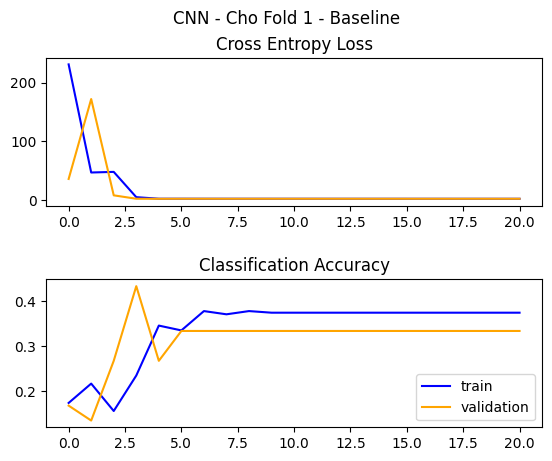

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 35ms/step - loss: 1.7335 - accuracy: 0.3333
Loss:  1.733463168144226
Accuracy: 33.33%
Fold 1 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_87 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

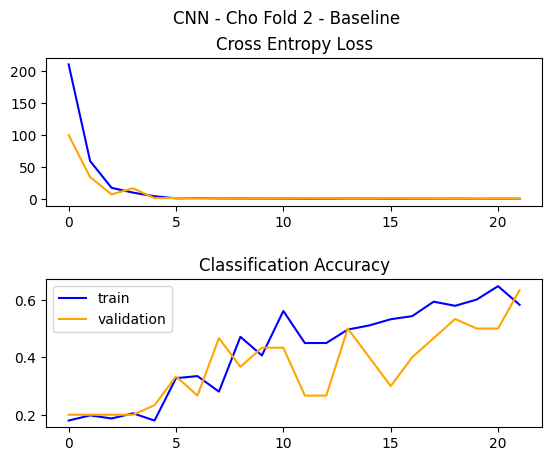

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 57ms/step - loss: 0.9221 - accuracy: 0.6333
Loss:  0.9221266508102417
Accuracy: 63.33%
Fold 2 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_89 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                          

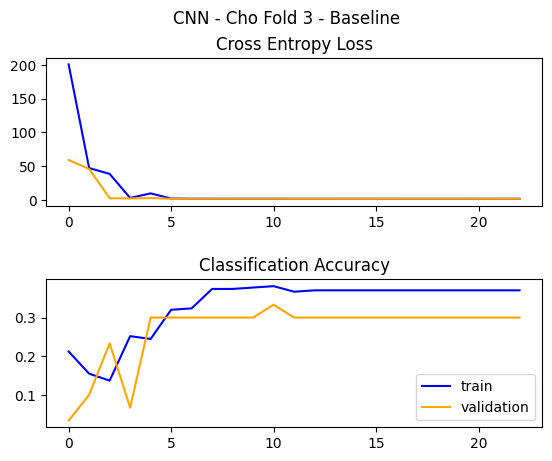

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 41ms/step - loss: 1.7012 - accuracy: 0.3000
Loss:  1.701232671737671
Accuracy: 30.00%
Fold 3 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_91 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

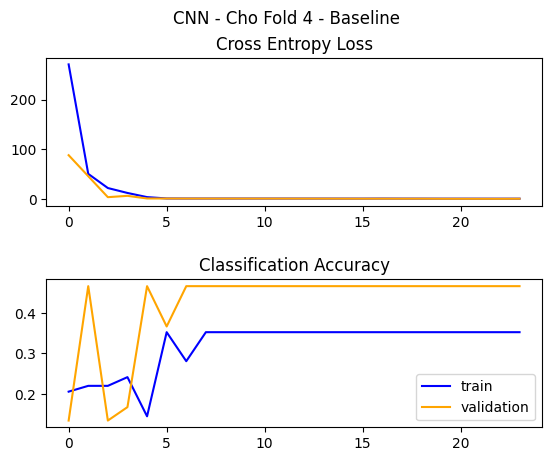

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 48ms/step - loss: 1.3914 - accuracy: 0.4667
Loss:  1.3914016485214233
Accuracy: 46.67%
Fold 4 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_93 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                          

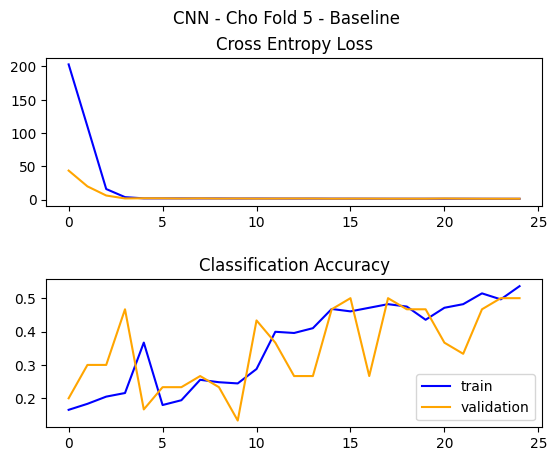

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 51ms/step - loss: 1.2188 - accuracy: 0.5000
Loss:  1.2187649011611938
Accuracy: 50.00%
Fold 5 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_95 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                          

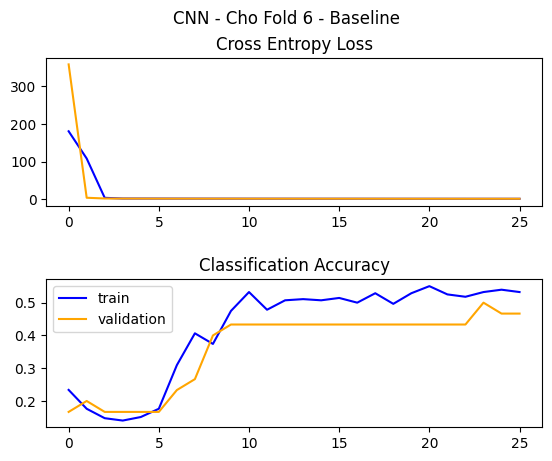

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 34ms/step - loss: 1.1295 - accuracy: 0.4667
Loss:  1.12945556640625
Accuracy: 46.67%
Fold 6 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_97 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                            

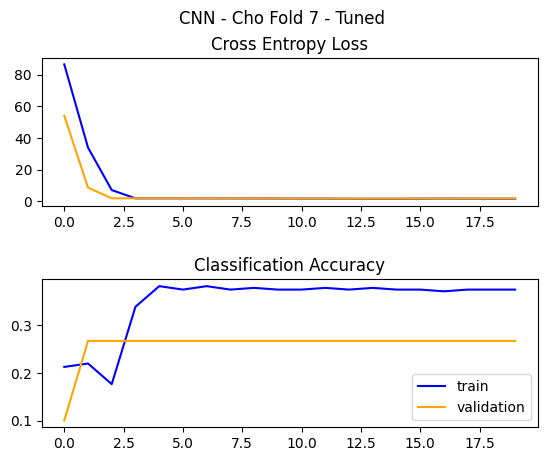

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 49ms/step - loss: 1.6669 - accuracy: 0.2667
Loss:  1.6669174432754517
Accuracy: 26.67%
Fold 7 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 3, 6, 32)          320       
                                                                 
 conv2d_99 (Conv2D)          (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                          

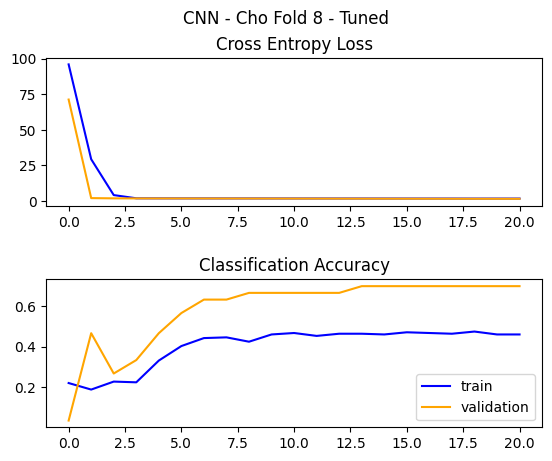

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 47ms/step - loss: 1.4738 - accuracy: 0.7000
Loss:  1.473775029182434
Accuracy: 70.00%
Fold 8 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_101 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                           

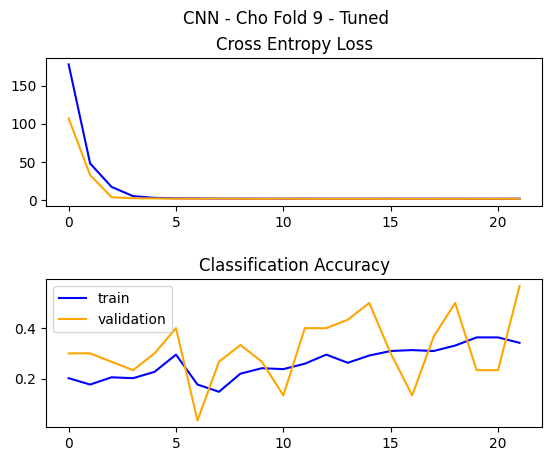

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 44ms/step - loss: 1.4207 - accuracy: 0.5667
Loss:  1.4207346439361572
Accuracy: 56.67%
Fold 9 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_103 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                          

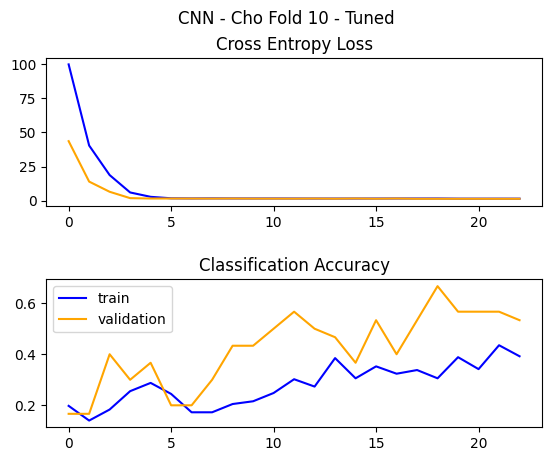

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 40ms/step - loss: 1.3725 - accuracy: 0.5333
Loss:  1.3725205659866333
Accuracy: 53.33%
Fold 10 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_105 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                         

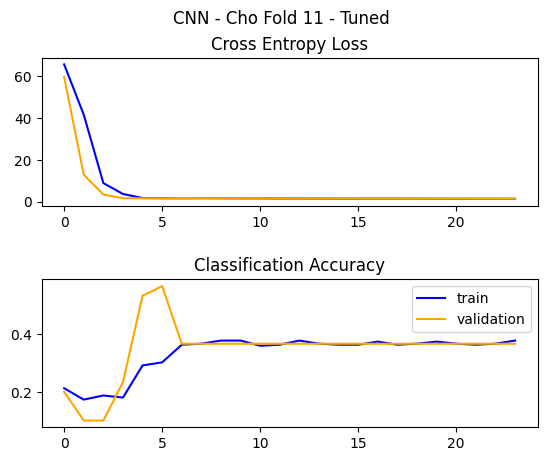

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 48ms/step - loss: 1.4074 - accuracy: 0.3667
Loss:  1.4073563814163208
Accuracy: 36.67%
Fold 11 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 278/278
New validation/labels length: 30/30
------------------------------------------------------------------
Building Model...
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_107 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 1, 3, 32)         0         
 g2D)                         

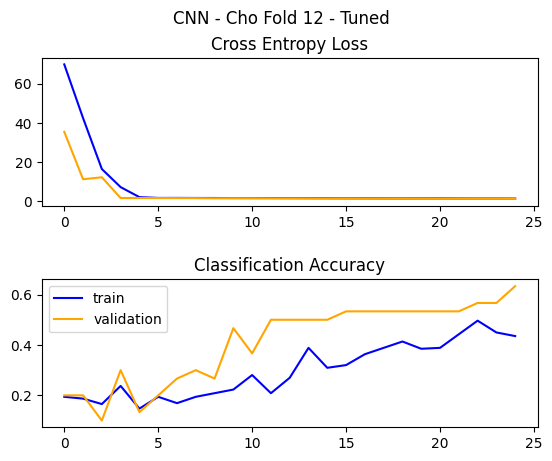

------------------------------------------------------------------
Evaluating Model...
1/1 [==============================] - 0s 55ms/step - loss: 1.3136 - accuracy: 0.6333
Loss:  1.3135755062103271
Accuracy: 63.33%
Fold 12 Complete!
------------------------------------------------------------------


In [191]:
#def run_Cho():
    
# load dataset
df_train, df_test, test, test_labels = load_Cho()

print("\nVerifying Data...")

print("Training: ")
print(df_train)
print("Testing: ")
print(df_test)

print("Data Verified!\n")
print("------------------------------------------------------------------")

# 10 fold cross-validation
# folds 1-6 are baselines and folds 7-12 are tuned models
# both baseline and tuned models run from epochs 20 - 25
model_Cho = {}
accuracy_folds = {}
for i in range(1,13): #debugging on tuned model
    print("Creating Validation Set...")

    (train_data, train_labels), (val_data, val_labels) = validation_Cho(df_train)

    print("------------------------------------------------------------------")
    print("Building Model...")

    if (i < 7):
        model_Cho[i-1] = build_model_CNN_baseline((3, 6, 1), 6) # 6 labels bcuz 0-5, but 0 is not used!
    else:
        model_Cho[i-1] = build_model_CNN_tuned((3, 6, 1), 6)

    print("------------------------------------------------------------------")
    print("Fitting Model...")

    # fit model
    if (i < 7):
        epochs = 20+i
    else:
        epochs = 20+(i-7)
    history_Cho = model_Cho[i-1].fit(train_data, train_labels, epochs=epochs, batch_size=64, validation_data=(val_data, val_labels), verbose=0)
    
    # show learning curves
    if (i < 7):
        show_diagnostics(history_Cho, "Cho Fold " + str(i) + " - Baseline", "validation")
    else:
        show_diagnostics(history_Cho, "Cho Fold " + str(i) + " - Tuned", "validation")

    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model_Cho[i-1].evaluate(val_data,  val_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}")

    # store accuracy
    accuracy_folds[i-1] = test_acc
    
    print(f"Fold {i} Complete!")
    print("------------------------------------------------------------------")

#run_Cho()

3/3 [==============================] - 0s 4ms/step
Explained Variance Ratio:  [0.38658589 0.19758651 0.12973475]
Sum of variance by these 3 components:  0.7139071507681813

Singular Values:  [23.29735166 16.65567345 13.4962064 ]
l =  2
i =  (array([ 0,  2,  3,  4,  5,  9, 10, 13, 18, 19, 20, 23, 24, 26, 27, 28, 30,
       32, 36, 40, 44, 46, 47, 48, 52, 53, 59, 63, 64, 67, 71, 72, 74],
      dtype=int64),)
l =  3
i =  (array([12, 25, 29, 33, 35, 39, 41, 42, 43, 49, 50, 58, 65], dtype=int64),)
l =  4
i =  (array([ 1,  6,  8, 16, 21, 34, 37, 45, 51, 57, 60, 62, 70, 75, 77],
      dtype=int64),)
l =  5
i =  (array([ 7, 11, 17, 31, 38, 55], dtype=int64),)


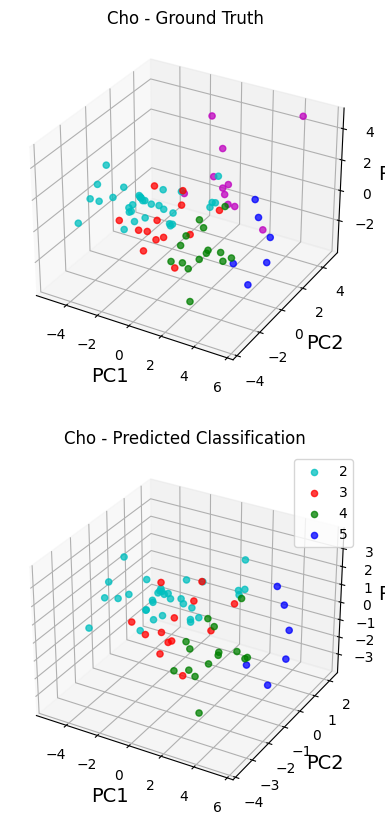

In [189]:
# predict labels
pred_labels = model_Cho[8].predict(test)
df_pred = np.argmax(pred_labels, axis=1)

# normalize data for plotting
df_test_3D = normalize_Cho(df_test)

# set 3 axis
Xax = df_test_3D[:,0]
Yax = df_test_3D[:,1]
Zax = df_test_3D[:,2]

# create figure variables
fig = plt.figure(figsize=(10,10), constrained_layout=False)
ax_truth = fig.add_subplot(2,1,1, projection='3d')
ax_pred = fig.add_subplot(2,1,2, projection='3d')
fig.patch.set_facecolor('white')
cdict = {0:'m', 1:'c', 2:'r', 3:'g', 4:'b', 5:'y'}
y = df_test.Ground_Truth_Cluster_ID

# ground truth figure
for l in np.unique(y):
    i = np.where(y==l)
    ax_truth.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l-1], s=20, alpha=0.75, label=l)

ax_truth.set_xlabel("PC1", fontsize=14)
ax_truth.set_ylabel("PC2", fontsize=14)
ax_truth.set_zlabel("PC3", fontsize=14)
ax_truth.set_title('Cho - Ground Truth')

# predicted figure
for l in np.unique(df_pred):
    i = np.where(y==l)

    #debug
    print("l = ", l)
    print("i = ",i)

    ax_pred.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l-1], s=20, alpha=0.75, label=l)

ax_pred.set_xlabel("PC1", fontsize=14)
ax_pred.set_ylabel("PC2", fontsize=14)
ax_pred.set_zlabel("PC3", fontsize=14)
ax_pred.set_title('Cho - Predicted Classification')

plt.legend()
plt.show()
plt.close()